In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount =True)

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/digits.zip'
!unzip $path

Streaming output truncated to the last 5000 lines.
 extracting: digits/1/54_39.jpg      
 extracting: digits/1/54_68.jpg      
  inflating: digits/1/55_11.jpg      
  inflating: digits/1/55_28.jpg      
 extracting: digits/1/55_76.jpg      
  inflating: digits/1/57_2.jpg       
  inflating: digits/1/57_30.jpg      
  inflating: digits/1/60_15.jpg      
  inflating: digits/1/60_44.jpg      
  inflating: digits/1/60_56.jpg      
  inflating: digits/1/60_68.jpg      
  inflating: digits/1/61_34.jpg      
 extracting: digits/1/61_37.jpg      
  inflating: digits/1/61_4.jpg       
 extracting: digits/1/61_50.jpg      
  inflating: digits/1/61_69.jpg      
  inflating: digits/1/61_75.jpg      
  inflating: digits/1/61_9.jpg       
 extracting: digits/1/62_64.jpg      
  inflating: digits/1/62_77.jpg      
  inflating: digits/1/64_25.jpg      
  inflating: digits/1/64_35.jpg      
  inflating: digits/1/64_38.jpg      
  inflating: digits/1/64_63.jpg      
  inflating: digits/1/64_75.jpg      

In [4]:
!rm -r digits/10

In [5]:
import os

In [6]:
par = 'digits'
dirs = os.listdir(par)

In [7]:
num_classes = len(dirs)

In [142]:
X = []
y = []

for folder_names in os.listdir(par):
  folder_path = os.path.join(par, folder_names)
  for file_names in os.listdir(folder_path):
    files_path = os.path.join(folder_path, file_names)
    img = cv2.imread(files_path)
    if img is not None:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      # ret, thresh = cv2.threshold(img_copy, 0.4, 255, cv2.THRESH_BINARY_INV)
      img_copy = cv2.resize(img, (32, 32))
      X.append(img_copy)
      y.append(int(folder_names))
    else:
      print(f"Failed: {files_path}")

X = np.array(X)
y = np.array(y)

X = X / 255

print(X.shape, y.shape)

(6299, 32, 32) (6299,)


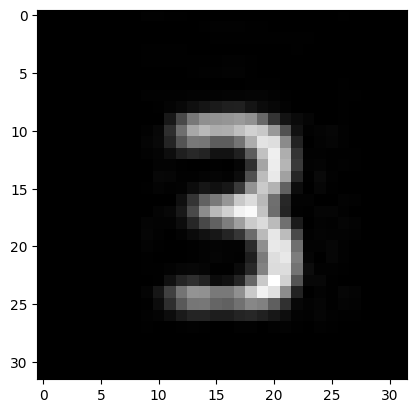

In [143]:
plt.imshow(X[5], 'gray')

In [144]:
X_thresh = []

for i in range(X.shape[0]):
  ret, thresh = cv2.threshold(X[i], 0.3, 1, cv2.THRESH_BINARY_INV)
  X_thresh.append(thresh)

X_thresh = np.asarray(X_thresh)

In [145]:
X = X_thresh.reshape(X_thresh.shape[0], X_thresh.shape[1], X_thresh.shape[2], 1)

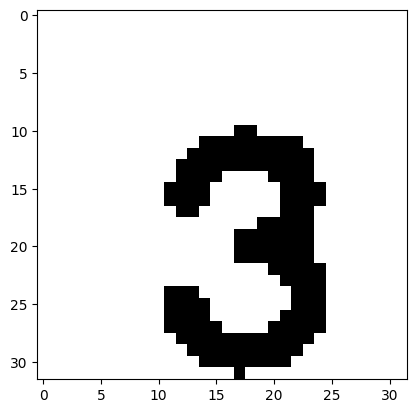

In [146]:
plt.imshow(X[9], 'gray')

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [148]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [149]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4031, 32, 32, 1)
(1008, 32, 32, 1)
(1260, 32, 32, 1)


In [150]:
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [151]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(4031, 10)
(1008, 10)
(1260, 10)


In [153]:
generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.35
)

In [154]:
generator.fit(X_train)

In [155]:
def get_model():
  filters = 64
  kernel1 = (5, 5)
  kernel2 = (3, 3)
  pool_size = (2, 2)
  nodes = 512

  model = keras.Sequential([
      Conv2D(filters, kernel1, activation='relu', input_shape=(32, 32, 1)),
      Conv2D(filters, kernel1, activation='relu'),
      MaxPooling2D(pool_size=pool_size),
      Conv2D(filters//2, kernel2, activation='relu'),
      Conv2D(filters//2, kernel2, activation='relu'),
      Dropout(0.5),
      Flatten(),
      Dense(nodes, activation='relu'),
      Dropout(0.4),
      Dense(num_classes, activation='softmax')
  ])

  model.compile(
      optimizer=Adam(lr = 1e-3),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  return model

In [156]:
model = get_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 dropout (Dropout)           (None, 8, 8, 32)          0         
                                                        

In [159]:
batchsize = 50
epochs = 10
steps = X_train.shape[0] // batchsize

with tf.device('/device:GPU:0'):
  history = model.fit_generator(
      generator.flow(X_train, y_train, batch_size=batchsize),
      validation_data=(X_val, y_val),
      steps_per_epoch=steps,
      epochs=epochs
  )

Epoch 1/10


<ipython-input-159-ad11ed139af8>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


80/80 [==============================] - 51s 634ms/step - loss: 0.1920 - accuracy: 0.9362 - val_loss: 0.0501 - val_accuracy: 0.9851
Epoch 2/10
80/80 [==============================] - 47s 582ms/step - loss: 0.1777 - accuracy: 0.9432 - val_loss: 0.0548 - val_accuracy: 0.9861
Epoch 3/10
80/80 [==============================] - 46s 580ms/step - loss: 0.2219 - accuracy: 0.9302 - val_loss: 0.0501 - val_accuracy: 0.9851
Epoch 4/10
80/80 [==============================] - 46s 577ms/step - loss: 0.1823 - accuracy: 0.9460 - val_loss: 0.0463 - val_accuracy: 0.9891
Epoch 5/10
80/80 [==============================] - 48s 603ms/step - loss: 0.1821 - accuracy: 0.9410 - val_loss: 0.0351 - val_accuracy: 0.9871
Epoch 6/10
80/80 [==============================] - 48s 597ms/step - loss: 0.1700 - accuracy: 0.9498 - val_loss: 0.0283 - val_accuracy: 0.9931
Epoch 7/10
80/80 [==============================] - 45s 564ms/step - loss: 0.1719 - accuracy: 0.9475 - val_loss: 0.0292 - val_accuracy: 0.9901
Epoch 8/10

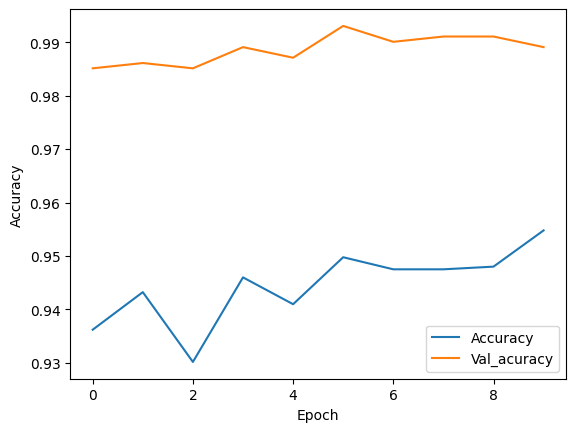

In [160]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(['Accuracy', 'Val_acuracy'])
plt.show()

In [161]:
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.06416163593530655
Test accuracy: 0.988095223903656


In [162]:
import pickle

In [163]:
with open("model_new.pkl", "wb") as f:
  pickle.dump(model, f)

In [164]:
with open("/content/drive/MyDrive/model_new.pkl", "wb") as f:
  pickle.dump(model, f)